In [22]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.constants as const
from beam.beams import electronbeam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from beam import interactions
from lens import profile
from scipy.interpolate import interp1d

path = '/media/robert/Data_Storage/Data/Super-Adiabatic_Ramp_Propagation/Assumed_Beta/'

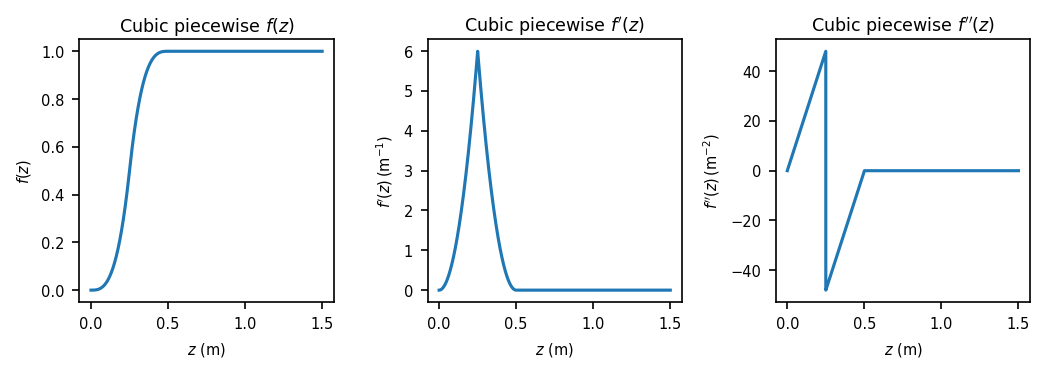

In [23]:
# First let's look at the f(z) function made solely of cubics
f = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 4*(z/z1)**3, lambda z: 4*((z-z1)/z1)**3+1, 1])
fp = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 12*z**2/z1**3, lambda z: 12*(z-z1)**2/z1**3, 0])
fpp = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 24*z/z1**3, lambda z: 24*(z-z1)/z1**3, 0])

Nz = 10000
z1 = 0.5
Z = 1.5
z = np.linspace(0, Z, Nz)
plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, f(z))
plt.title(r"Cubic piecewise $f(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f(z)$")

plt.subplot(gs[0, 1])
plt.plot(z, fp(z))
plt.title(r"Cubic piecewise $f'(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f'(z)\,\mathrm{(m^{-1})}$")

plt.subplot(gs[0, 2])
plt.plot(z, fpp(z))
plt.title(r"Cubic piecewise $f''(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f''(z)\,\mathrm{(m^{-2})}$")

plt.tight_layout()
plt.show()

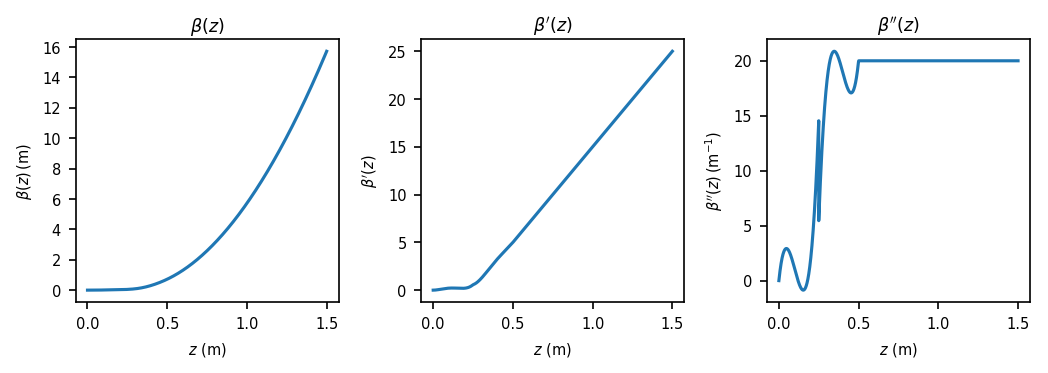

In [24]:
# Now let's look at the beta function that result from this f(z)
g = lambda z: (z-z0)**2/bs + bs - 1/kb
gp = lambda z: 2*(z-z0)/bs
gpp = lambda z: 2/bs

b = lambda z: 1/kb + g(z)*f(z)
bp = lambda z: g(z)*fp(z) + gp(z)*f(z)
bpp = lambda z: g(z)*fpp(z)+2*gp(z)*fp(z)+gpp(z)*f(z)

kb = 210.37
bs = 0.1
z0 = 0.25
plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")

plt.subplot(gs[0, 1])
plt.plot(z, bp(z))
plt.title(r"$\beta'(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta'(z)$")

plt.subplot(gs[0, 2])
plt.plot(z, bpp(z))
plt.title(r"$\beta''(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta''(z)\,\mathrm{(m^{-1})}$")

plt.tight_layout()
plt.show()

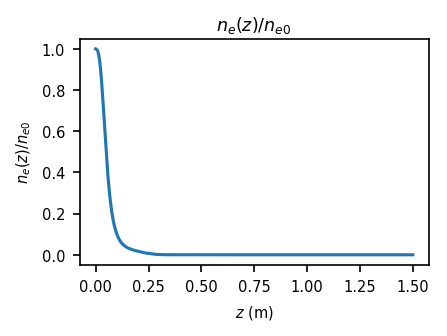

In [25]:
# Finally, let's look at the plasma ramp that result from this f(z)
ne = lambda z: 1/(kb**2*b(z)**2)*(1+bp(z)**2/4)-bpp(z)/(2*kb**2*b(z))
plt.figure(figsize=(3, 2), dpi=150)
plt.plot(z, ne(z))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.show()

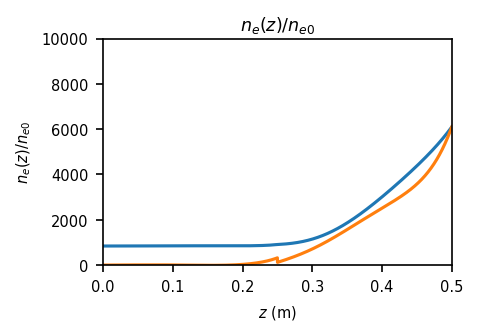

In [26]:
# Finally, let's look at the plasma ramp that result from this f(z)
positive = 4*kb+kb*(g(z)*fp(z)+gp(z)*f(z))**2
negative = 2*(1+kb*g(z)*f(z))*(g(z)*fpp(z)+2*gp(z)*fp(z)+gpp(z)*f(z))
plt.figure(figsize=(3, 2), dpi=150)
plt.plot(z, positive, z, negative)
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.xlim([0, z1])
plt.ylim([0,10000])
plt.show()

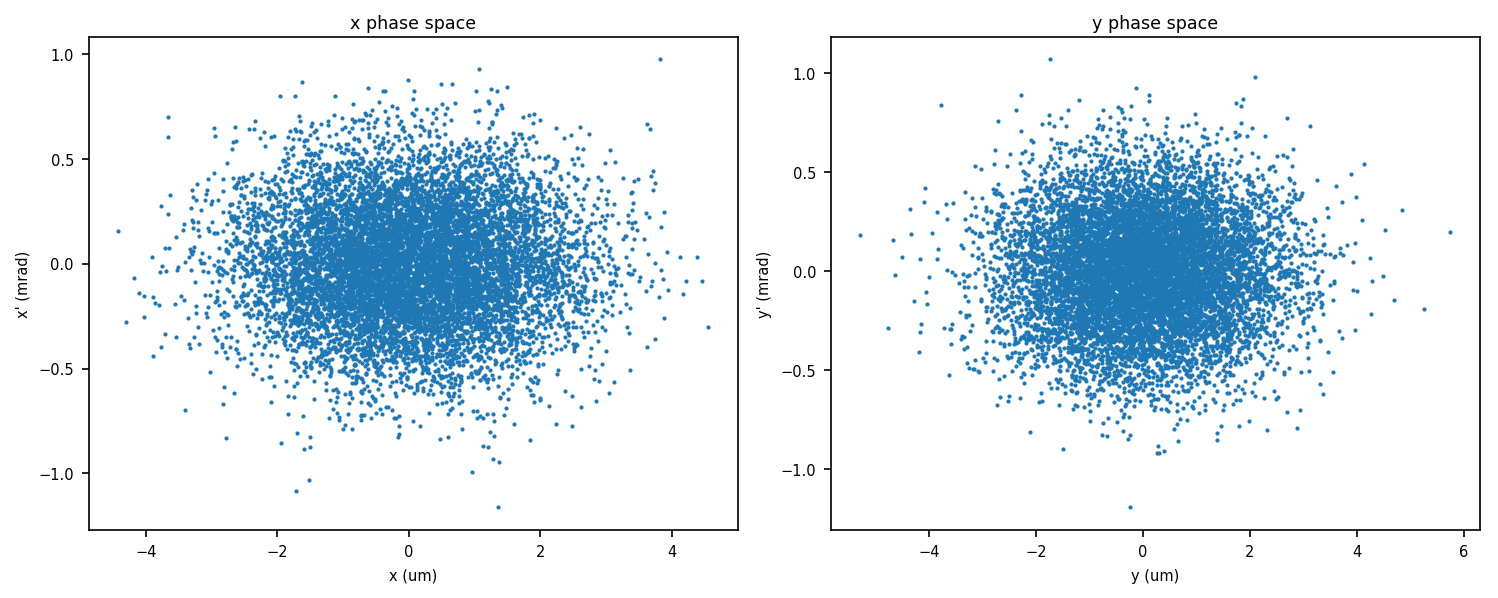

In [27]:
# Lets test this using the macro particle propagation
# Create the plasma desnity
Nz = 2000
zsim = np.linspace(0, Z, Nz)
zsim *= 1e6
#ne = fne(zsim)
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return 0.5*ne(z*1e-6)
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()
# Create the electron beam
gamma = 20000 # Beam relativistic Lorentz factor
betaBeam = b(0)
alphaBeam = bp(0)/(-2)
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gamma,
    'emittance' : 7e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

In [28]:
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, zsim, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, Z, m)
dz = Z/(m-1)
beam_ne = 0.5*ne(beam_z)

Initial emittance: 6.9476 um rad
Final emittance:   6.9475 um rad


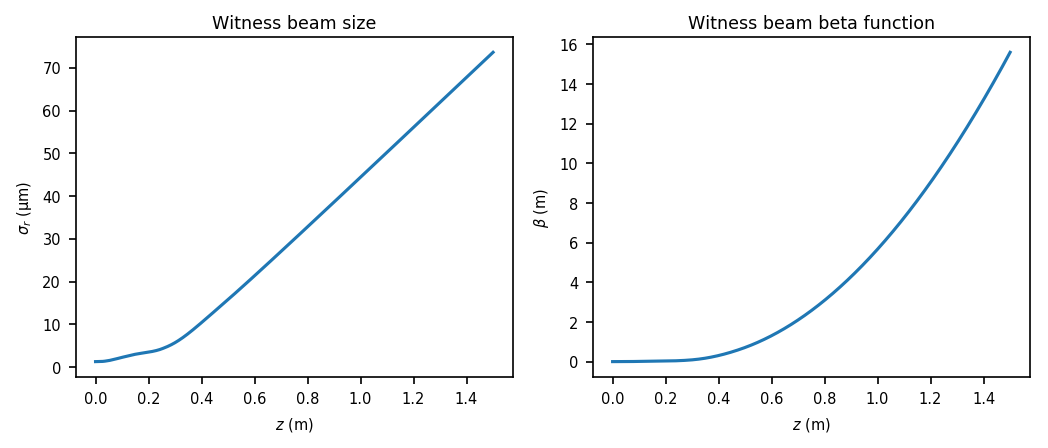

In [29]:
# Check to make sure everything seems correct
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gamma
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta)
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')

plt.tight_layout()
plt.show()

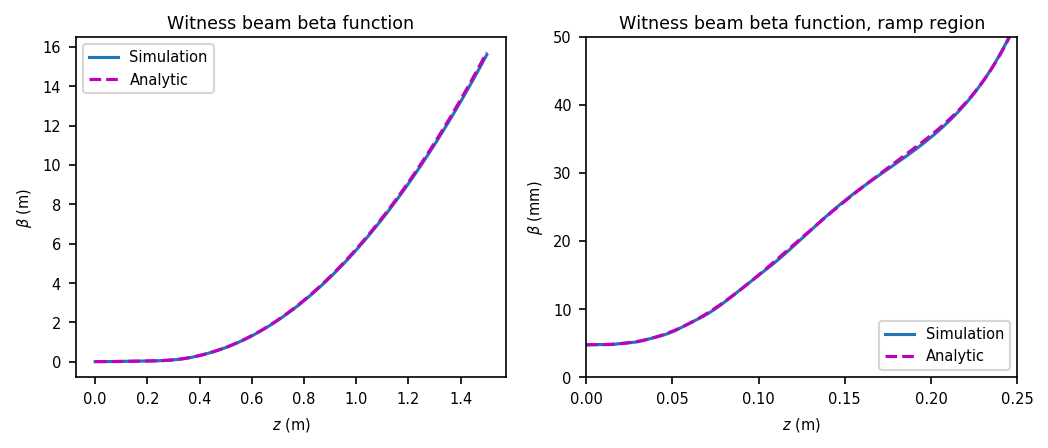

In [30]:
# Compare to the analytic values
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_beta)
plt.plot(z, b(z), 'm--')
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')
plt.legend(['Simulation', 'Analytic'])

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta*1e3)
plt.plot(z, b(z)*1e3, 'm--')
plt.title('Witness beam beta function, ramp region')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend(['Simulation', 'Analytic'])
plt.xlim([0, 0.25])
plt.ylim([0, 50])

plt.tight_layout()
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


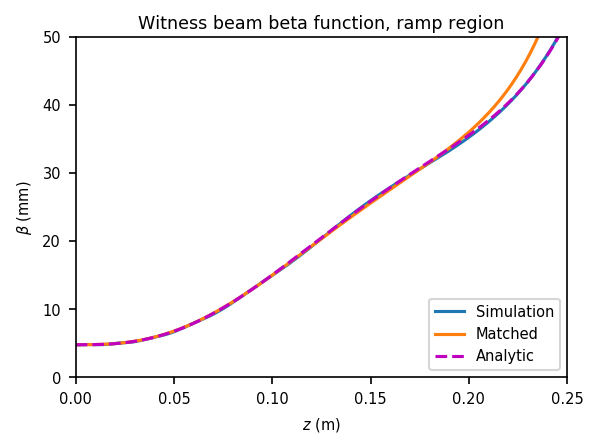

In [31]:
# Compare to the matched beam size
eps0 = const.physical_constants['electric constant'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
c = const.physical_constants['speed of light in vacuum'][0]
sigmaM = np.sqrt(c*np.sqrt(me*eps0/beam_ne/1e23/e**2)*1e6*np.sqrt(2*gamma)*7.0/gamma)
betaM = (sigmaM*1e-6)**2 / 7e-6 * gamma

plt.figure(figsize=(4, 3), dpi=150)
plt.plot(beam_z, beam_beta*1e3)
plt.plot(beam_z, betaM*1e3)
plt.plot(z, b(z)*1e3, 'm--')
plt.title('Witness beam beta function, ramp region')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.legend(['Simulation', 'Matched', 'Analytic'])
plt.xlim([0, 0.25])
plt.ylim([0, 50])

plt.tight_layout()
plt.show()

0.2 Negative plasma density: False
0.3 Negative plasma density: False
0.4 Negative plasma density: False
0.5 Negative plasma density: False


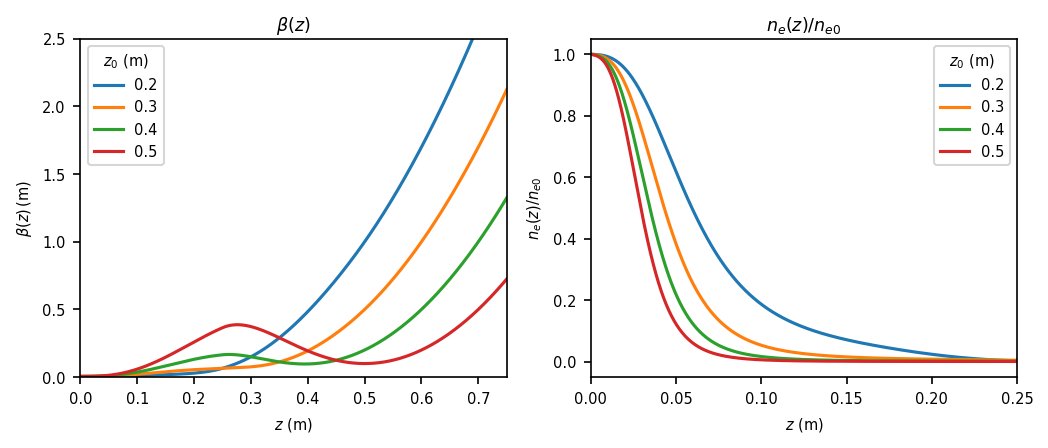

In [73]:
# Lets look at the beta function and plasma density for various waist locations. 
z1 = 0.5
kb = 210.37
bs = 0.1
z0Arr = [0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
for i in z0Arr:
    z0 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0, 0.75])
plt.ylim([0, 2.5])

plt.subplot(gs[0, 1])
for i in z0Arr:
    z0 = i
    plt.plot(z, ne(z))
    print(z0, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0.0, 0.25])

plt.tight_layout()
plt.show()
# Anything above z0=0.5 leads to negative plasma density. Presumably this has something to do with z1=0.5
# The lowest possble waist location seems to be z0=0.153

0.2 Negative plasma density: False
0.3 Negative plasma density: False
0.4 Negative plasma density: False
0.5 Negative plasma density: False


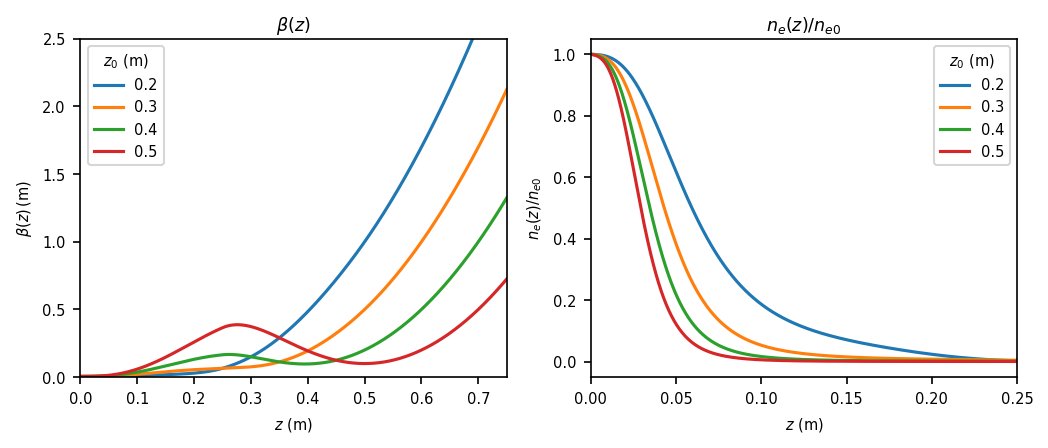

In [83]:
# Lets look at the beta function and plasma density for various waist locations. 
z1 = 0.5
kb = 210.37
bs = 0.1
z0Arr = [0.2, 0.3, 0.4, 0.5]
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
for i in z0Arr:
    z0 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0, 0.75])
plt.ylim([0, 2.5])

plt.subplot(gs[0, 1])
for i in z0Arr:
    z0 = i
    plt.plot(z, ne(z))
    print(z0, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0.0, 0.25])

plt.tight_layout()
plt.show()
# Anything above z0=0.5 leads to negative plasma density. Presumably this has something to do with z1=0.5
# The lowest possble waist location seems to be z0=0.153

0.1 Negative plasma density: False
0.15 Negative plasma density: False
0.2 Negative plasma density: False
0.251 Negative plasma density: False
0.3 Negative plasma density: False


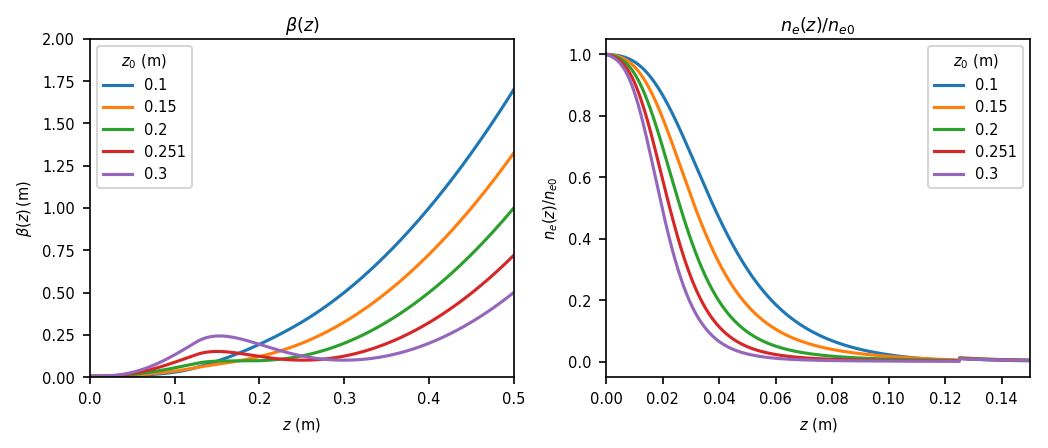

In [96]:
# Lets look at the beta function and plasma density for various waist locations. 
z1 = 0.25
kb = 210.37
bs = 0.1
z0Arr = [0.1, 0.15, 0.2, 0.251, 0.3]
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
for i in z0Arr:
    z0 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0, 0.5])
plt.ylim([0, 2.0])

plt.subplot(gs[0, 1])
for i in z0Arr:
    z0 = i
    plt.plot(z, ne(z))
    print(z0, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0.0, 0.15])

plt.tight_layout()
plt.show()
# The vacuum waist can not appear exactly at the ramp width, z0=z1 doesn't work

0.4 Negative plasma density: False
0.5 Negative plasma density: False
0.6 Negative plasma density: False
0.7 Negative plasma density: False
0.8 Negative plasma density: False
0.9 Negative plasma density: False
1.0 Negative plasma density: False


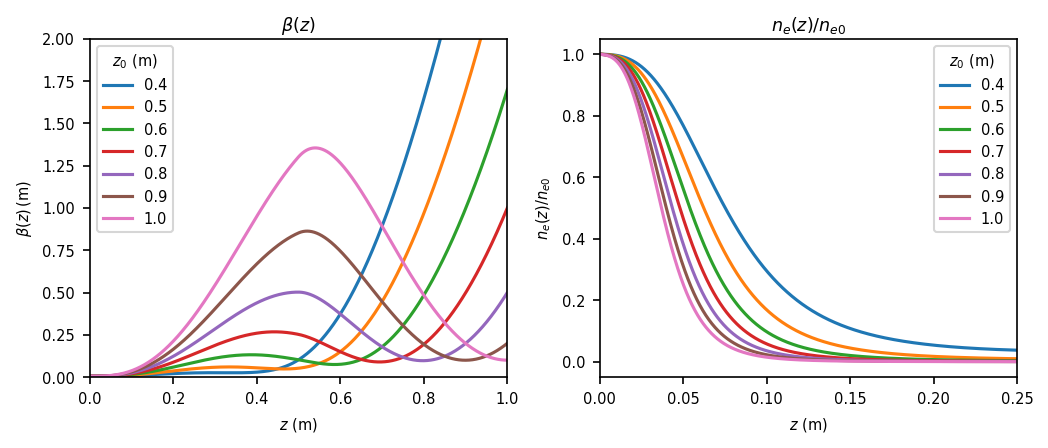

In [114]:
# Lets look at the beta function and plasma density for various waist locations. 
z1 = 1.0
kb = 210.37
bs = 0.1
z0Arr = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
for i in z0Arr:
    z0 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0, 1.0])
plt.ylim([0, 2.0])

plt.subplot(gs[0, 1])
for i in z0Arr:
    z0 = i
    plt.plot(z, ne(z))
    print(z0, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0.0, 0.25])

plt.tight_layout()
plt.show()

0.4 Negative plasma density: False
0.5 Negative plasma density: False
0.6 Negative plasma density: False
0.7 Negative plasma density: False
0.8 Negative plasma density: False
0.9 Negative plasma density: False
1.0 Negative plasma density: False


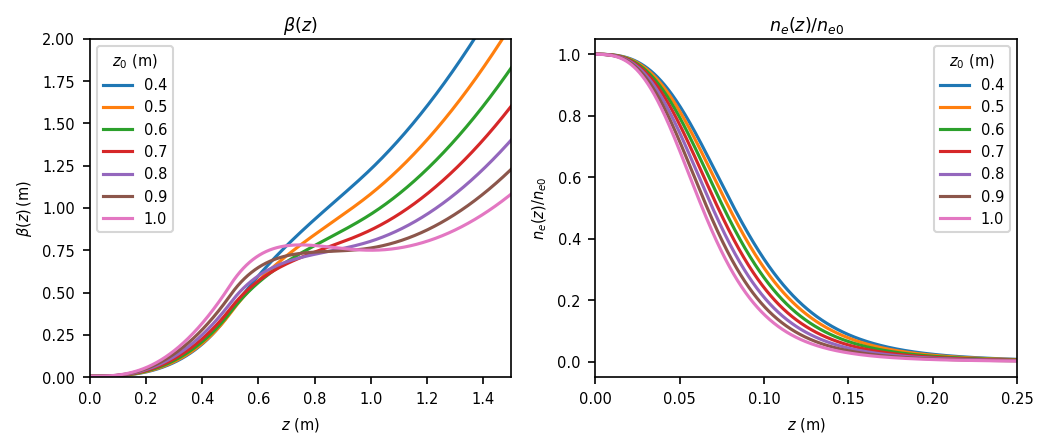

In [130]:
# Lets look at the beta function and plasma density for various waist locations. 
z1 = 1.0
kb = 210.37
bs = 0.75
z0Arr = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
for i in z0Arr:
    z0 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0, 1.5])
plt.ylim([0, 2.0])

plt.subplot(gs[0, 1])
for i in z0Arr:
    z0 = i
    plt.plot(z, ne(z))
    print(z0, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z0Arr, title=r'$z_0$ (m)')
plt.xlim([0.0, 0.25])

plt.tight_layout()
plt.show()